In [7]:
import numpy as np
from numba import njit
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from typing import Iterable

In [3]:
@njit
def count_errors_1(order_info: np.ndarray) -> np.ndarray:
    """
    Count errors in order_info for each mu in [[1, m]]
    Complexity: O(m^2)

    Args:
        order_info: array of order information c in {0, 1}^m

    Return:
        [|| E_k - c||_1 for k in [[1, m]]] np.ndarray in [[0, m]]^m
        with E_k = [1] * k + [0] * (m - k)
    """
    m = order_info.shape[0]
    e = np.zeros(m)
    errors = np.zeros(m)
    for i in range(m):
        e[i] = 1
        errors[i] = np.sum(np.abs(e - order_info))
    
    return errors

In [3]:
@njit
def count_errors(order_info: np.ndarray) -> np.ndarray:
    """
    Count errors in order_info for each mu in [[1, m]]
    Complexity: O(m)

    Args:
        order_info: array of order information c in {0, 1}^m

    Return:
        [|| E_k - c||_1 for k in [[1, m]]] np.ndarray in [[0, m]]^m
        with E_k = [1] * k + [0] * (m - k)
    """
    m = order_info.shape[0]
    
    errors = np.zeros(m)
    current_error = np.sum(order_info)

    for i in range(m):
        current_error = current_error + 1 - 2 * order_info[i]
        errors[i] = current_error
    
    return errors

In [4]:
@njit
def count_errors_2(order_info: np.ndarray) -> np.ndarray:
    """
    Count errors in order_info for each mu in [[1, m]]
    Complexity: O(m)

    Args:
        order_info: array of order information c in {0, 1}^m

    Return:
        [|| E_k - c||_1 for k in [[1, m]]] np.ndarray in [[0, m]]^m
        with E_k = [1] * k + [0] * (m - k)
    """
    m = order_info.shape[0]
    errors = np.sum(order_info) + np.arange(1, m + 1) - 2 * np.cumsum(order_info)

    return errors

In [6]:
for _ in tqdm(range(1_000)):
    order_test = np.random.randint(2, size=200)
    assert np.all(count_errors_1(order_test) == count_errors(order_test))
    assert np.all(count_errors_2(order_test) == count_errors(order_test))

  0%|          | 0/1000 [00:00<?, ?it/s]

In [8]:
order_test = np.random.randint(2, size=10_000)
count_errors(order_test)
count_errors_1(order_test)
count_errors_2(order_test)
order_test

array([0, 0, 1, ..., 1, 0, 0])

In [9]:
%%timeit
_ = count_errors(order_test)

10.6 µs ± 172 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [10]:
%%timeit
_ = count_errors_1(order_test)

157 ms ± 2.53 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [11]:
%%timeit
_ = count_errors_2(order_test)

12.6 µs ± 79.9 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [29]:
def god_model_generator(n_cat: int, mu: int, pi: float) -> int:
    """
    Generate a x in [[1, n_cat]] from GOD model with parameters mu and pi

    Args:
        n_cat: number of categories
        mu: true category
        pi: probability of true comparison (pi > 0.5)
    
    Return:
        x: generated category
    """
    false_comparaisons = np.random.binomial(1, 1 - pi, size=n_cat)
    order = np.arange(1, n_cat + 1) <= mu
    # observed_order[i] = (i <= mu) if false_comparaisons[i] == 0 else ((i <= mu) + 1) % 2
    observed_order = (false_comparaisons + order) % 2

    nb_errors = count_errors(observed_order)
    x = np.random.choice(np.where(nb_errors == nb_errors.min())[0]) + 1

    return x

In [30]:
def god_model_sample(n_cat: int, mu: int, pi: float, n_sample: int) -> np.ndarray:
    """
    Generate n_sample x in [[1, n_cat]] from GOD model with parameters mu and pi

    Args:
        n_cat: number of categories
        mu: true category
        pi: probability of error
        n_sample: number of samples
    
    Return:
        x: generated categories (n_sample,)
    """
    x = np.empty(n_sample, dtype=int)
    for i in range(n_sample):
        x[i] = god_model_generator(n_cat, mu, pi)
    
    return x

In [32]:
xs = god_model_sample(10, 5, 0.9, 10_000)

In [33]:
xs.min()

1

(array([  71.,  140.,  424.,  815., 7144.,  785.,  416.,  109.,   70.,
          26.]),
 array([ 1. ,  1.9,  2.8,  3.7,  4.6,  5.5,  6.4,  7.3,  8.2,  9.1, 10. ]),
 <BarContainer object of 10 artists>)

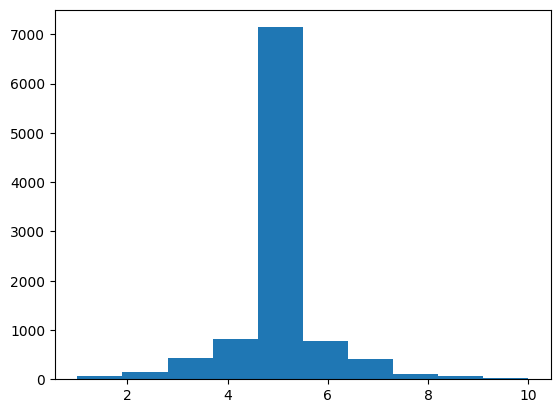

In [32]:
plt.hist(xs, bins=10)

In [54]:
def enumerate_order_info(n_cat: int) -> Iterable[tuple[int, np.ndarray]]:
    """
    Enumerate all possible order information for n_cat categories
    Complexity: O(2^n_cat * n_cat)

    Args:
        n_cat: number of categories
    
    Return:
        order_info: all possible order information (n_cat, 2^n_cat)
    """
    order_info = np.zeros(n_cat, dtype=int)
    for i in range(2 ** n_cat):
        yield i, order_info
        for j in range(n_cat):
            order_info[j] = (order_info[j] + 1) % 2
            if order_info[j] == 1:
                break

In [55]:
def get_all_errors(n_cat: int) -> np.ndarray:
    """
    Generate all possible errors for n_cat categories
    Complexity: O(2^n_cat * n_cat)

    Args:
        n_cat: number of categories
    
    Return:
        errors: all possible errors (n_cat, n_cat)
    """
    all_errors = np.zeros((2 ** n_cat, n_cat), dtype=int)
    for i, order_info in enumerate_order_info(n_cat):
        all_errors[i] = count_errors(order_info)
    
    return all_errors

In [56]:
get_all_errors(3)

array([[1, 2, 3],
       [0, 1, 2],
       [2, 1, 2],
       [1, 0, 1],
       [2, 3, 2],
       [1, 2, 1],
       [3, 2, 1],
       [2, 1, 0]])

In [ ]:
get_all_errors(3)

array([[1, 2, 3],
       [0, 1, 2],
       [2, 1, 2],
       [1, 0, 1],
       [2, 3, 2],
       [1, 2, 1],
       [3, 2, 1],
       [2, 1, 0]])

In [118]:
def probability_distribution_x_given_pi(x: int, pi: float, n_cat: int) -> np.ndarray:
    """
    Compute P(x | mu, pi)
    Complexity: O(2^n_cat * n_cat)

    Args:
        x: observed category
        mu: true category
        pi: probability of error
        n_cat: number of categories
    
    Return:
        [ P(x | mu, pi) for mu in [[1, n_cat]] ]
    """
    all_errors = get_all_errors(n_cat)
    all_mins = np.min(all_errors, axis=1)[:, None] == all_errors
    nb_mins = np.sum(all_mins, axis=1)

    p = np.zeros(n_cat)
    
    for mu in range(1, n_cat + 1):
        for i in range(2 ** n_cat):
            if all_mins[i, x - 1]:
                loc_p = pi ** (n_cat - all_errors[i, mu - 1]) * (1 - pi) ** all_errors[i, mu - 1]
                loc_p /= nb_mins[i]
                p[mu - 1] += loc_p
    return p
            

In [117]:
probability_distribution_x_given_pi(2, 0.7, 8)

array([0.15298657, 0.35696867, 0.15298657, 0.09952268, 0.07012058,
       0.05374268, 0.04252658, 0.03727868])

In [119]:
probability_distribution_x_given_pi(2, 0.7, 8)

array([0.15298657, 0.35696867, 0.15298657, 0.09952268, 0.07012058,
       0.05374268, 0.04252658, 0.03727868])

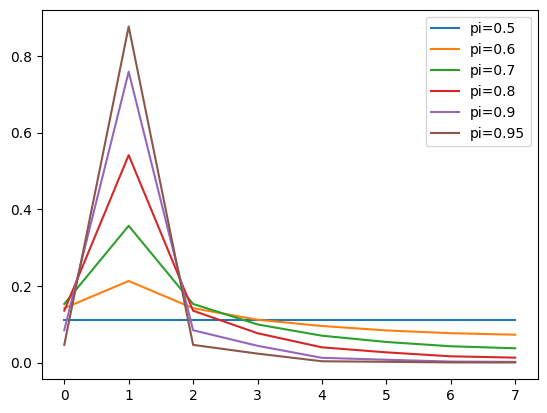

In [44]:
for pi in [0.5, 0.6, 0.7, 0.8, 0.9, 0.95]:
    plt.plot(probability_distribution_x_given_pi(2, pi, 8), label=f"pi={pi}")
plt.legend()

In [45]:
def probability_distribution_xs_given_pi(xs: np.ndarray, pi: float, n_cat: int) -> np.ndarray:
    """
    Compute P(x^1, ..., x^n | mu, pi)
    Complexity: O(2^n_cat * n_cat * n) with n = xs.shape[0]

    Args:
        xs: observed categories (n,)
        mu: true category
        pi: probability of error
        n_cat: number of categories
    
    Return:
        [ P(x^1, ..., x^n | mu, pi) for mu in [[1, n_cat]] ]
    """
    p = np.ones(n_cat)
    for x in xs:
        p *= probability_distribution_x_given_pi(x, pi, n_cat)
    
    return p

In [59]:
n_cat = 7
xs = god_model_sample(n_cat, 5, 0.7, 20)

probability_distribution_xs_given_pi(xs, 0.9, n_cat)

array([2.36017845e-40, 2.07082697e-35, 1.25962671e-30, 5.36446635e-23,
       3.28482258e-21, 9.19837388e-24, 2.24502857e-29])

In [46]:
def estimate_mu_given_pi(xs: np.ndarray, pi: float, n_cat: int) -> np.ndarray:
    """
    Compute P(mu | x^1, ..., x^n, pi)
    Complexity: O(2^n_cat * n_cat * n) with n = xs.shape[0]

    Args:
        xs: observed categories (n,)
        pi: probability of error
        n_cat: number of categories
    
    Return:
        [ P(mu | x^1, ..., x^n, pi) for mu in [[1, n_cat]] ]
    """
    p = probability_distribution_xs_given_pi(xs, pi, n_cat)
    return p.argmax() + 1

In [110]:
n_cat = 8
seed = np.random.randint(100)
print(f"{seed=}")
np.random.seed(seed)
xs = god_model_sample(n_cat, 5, 0.51, 20)
xs

seed=8


array([1, 2, 6, 6, 8, 8, 3, 7, 3, 3, 8, 2, 4, 1, 7, 8, 5, 1, 5, 2])

pi=0.5, distrib.argmax() + 1=1
pi=0.7, distrib.argmax() + 1=3
pi=0.8, distrib.argmax() + 1=3
pi=0.95, distrib.argmax() + 1=5
pi=0.99, distrib.argmax() + 1=5


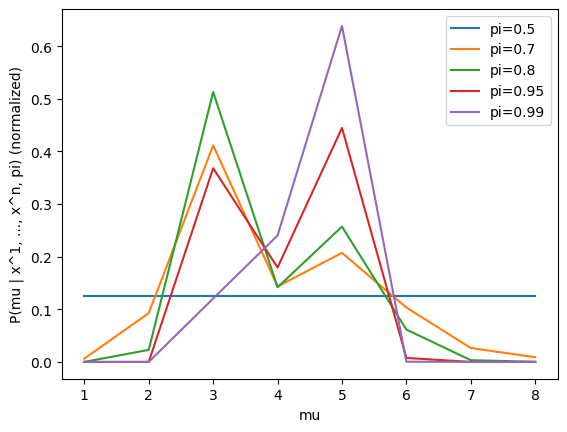

In [116]:
for pi in [0.5, 0.7, 0.8, 0.95, 0.99]:
    distrib = probability_distribution_xs_given_pi(xs, pi, n_cat)
    print(f"{pi=}, {distrib.argmax() + 1=}")
    plt.plot(np.arange(1, n_cat + 1), distrib / distrib.sum(), label=f"pi={pi}")
plt.xlabel("mu")
plt.ylabel("P(mu | x^1, ..., x^n, pi) (normalized)")
plt.legend()

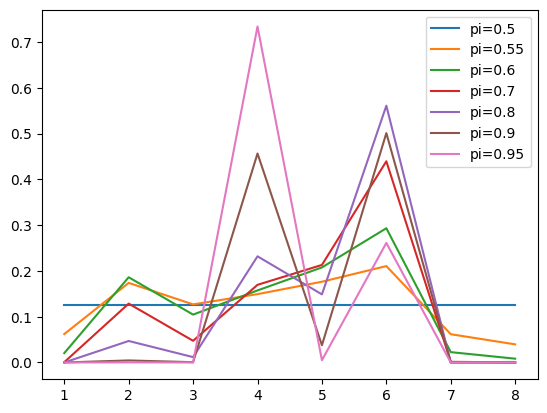 
seed = 17

In [ ]:
get_all_errors(3)

array([[1, 2, 3],
       [0, 1, 2],
       [2, 1, 2],
       [1, 0, 1],
       [2, 3, 2],
       [1, 2, 1],
       [3, 2, 1],
       [2, 1, 0]])